# Final Challenge. COVID-19 diagnosis using acoustics.
##[Inspired in the DICOVA Challenge at Interspeech 2021](https://dicova2021.github.io) 
 ## Speech Technologies for Health

University Carlos III Madrid

Elisa Ramírez Candela

César Caramazana Zarzosa 
____


Instructor: Carmen Peláez Moreno

# Abstract

In this Dicova challenge the objective is to discriminate between COVID-affected and COVID-free patients using audio recordings of either coughs, breaths or speech. A dataset is provided, as well as a default feature extraction method to obtain the Mel Spectrogram (MFCC) of a wav file. The baseline is stablished using three classical Machine Learning approaches from the sci-kit learn library: a Logistic Regressor, a Random Forest classifier and a Multi Layer Perceptron. 

We propose two distinct methodologies: 1) a Convolutional Neural Network that uses the MFCC matrix as input and extracts the visual information contained in the frequecy domain, and 2) an ensemble method of light-weighted classifiers.

Performance was measured in terms of Area under the ROC curve (AUC) and compared against the baseline. We found out that the CNN approach, despite being the solution that achieved the highest rank in the original challenge, couldn't compete in our scenario due to the lack of data; and that the Ensemble method improved the stand-alone Random Forest and Logistic Regressor but still was outperformed by the Multilayer Perceptron. 

# Import

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa, librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random, warnings, os
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
from IPython.display import clear_output
import IPython.display as ipd
import os
import shutil
import subprocess
!apt install tree
!apt-get install poppler-utils
!pip install pdf2image
from pdf2image import convert_from_path
from IPython.display import display, Image
warnings.filterwarnings("ignore")
%matplotlib inline


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.86.1-0ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Local dataset
Configuring the data folders and uploading the dataset.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

'''
TO DO: Here, you should configure the path to the folder in which you have downloaded 
the materials.
'''
myDicova = '/content/drive/MyDrive/ColabNotebooks/Speech/FINAL_PROJECT/'


rootdir= os.path.join(myDicova);

Mounted at /content/drive


In [ ]:
'''
Names of the folders that will contain the dataset, the labels and the lists of 
files.

TO DO: the data splits in the datasetdir must be kept unaltered to provide the 
results.

'''
challengedir = rootdir #+ '/dicova_challenge_4colab_students/'
datasetdir = challengedir + 'DiCOVA_Train_Val_Data_Release/' 
listsdir=datasetdir+'/LISTS/'
audiodir_pre=datasetdir+'Coswara-Data/Extracted_data_pre/'
audiodir=datasetdir+'Coswara-Data/Extracted_data/'
metadatafil=datasetdir+'/metadata.csv'


'''
Names for the folders that will contain the processed data.
'''
datadir= challengedir + 'data'
feature_dir= challengedir +'feats'


'''
Names for the configuration files.
TO DO: here you should provide new configurations for the your proposed features
and models.
'''
feats_config= challengedir +'conf/feature.conf'
train_config= challengedir +'conf/train.conf'


Here we need to set the correct paths to the data chosen in the files that contain the list of wav file.

In [ ]:
'''
The data offers three types of wav recordings: cough, breathing and speech. 
You need to modify the paths to refer to the location of your dataset.
TO DO: chose the kind/s of input wav recordings to use.
'''
cough_list = datadir + '/cough.scp';
breathing_list = datadir + '/breathing.scp';
speech_list = datadir + '/speech.scp';
all_list = datadir + '/all.scp';
chosen_list = datadir + '/wav.scp';

filelist = [];
y_text = [];
y = [];

'''
TO DO: modify this variable to chose cough, breathing or speech. 
The chosen ones need to be in copied in wav.scp.
'''

filen = breathing_list
filen = cough_list
filout = chosen_list

'''
Now, we read the file containing the paths to the audio files to 'lines'.
TO DO: substitute the target route in the replace command with that corresponding
to your file.  
'''
with open(filen, 'r') as f:
    lines = f.read().split('\n')
   
for line in lines[:-1]:
    line = line.replace('../DiCOVA_Train_Val_Data_Release/Coswara-Data/Extracted_data/', '/content/drive/MyDrive/ColabNotebooks/Speech/FINAL_PROJECT/DiCOVA_Train_Val_Data_Release/Coswara-Data/Extracted_data/').split('	')
    line_x = line[0];
    filelist.append(line_x);

with open(filout, 'w') as f:
  for line in filelist:
        f.write(line)
        f.write('\n')
     

# The training and validation partitions are in folds 1 to 5 in the data folder 
# their labels.


# Methodology

## Feature extraction.


For the task we selected the dataset containing **recordings of coughs** from patients with and without Covid. The data were heavily imbalanced, with an approximate proportion of 90-10% samples of non-Covid and Covid respectively. 

The feature extraction was done independently for each of the two classifiers we propose:
  * For the CNN, we extracted the MFCC spectrogram with 15 coefficients and hop size of 512, without deltas. The audio was previously preprocessed first by eliminating silent segments and then by trimming or padding the signal to a length of 150000 samples with the aim of obtaining a fixed size MFCC matrix that could be batched during training. With the selected hyperparameters, these matrices were (341, 15). 
  * For the ensemble models we added the deltas to the MFCC, after applying the same preprocessing steps. 

  An overview of the pipeline (for the MFCC without deltas) is shown in the figure below.

  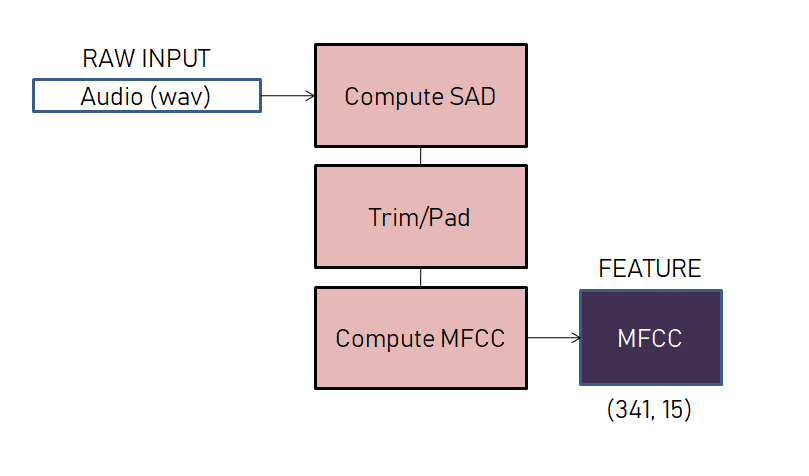

  While there were minor modifications in the hyperparameters, no big changes were made with respect to the default feature extraction pipeline in the interest of focusing on the classification methods. 


In [ ]:
'''
======= Feature extraction ========

TO DO: Run this cell to extract the features everytime you change the feature 
extraction configuration in feats_config. 

'''
drive.mount('/content/drive', force_remount=True)

# If featuredir doesn't exist, then create it.
%mkdir -p $feature_dir
wavfile_original = datadir + '/wav.scp'
#wavefile = dataugmentation(wavfile_original)
wavfile = datadir + '/wav.scp'


%cd $challengedir
%run -i feature_extraction.py -c $feats_config -i $wavfile -o $feature_dir

%cp $feature_dir/feats.scp $datadir/feats.scp
      

Show some examples of the features.

In [ ]:
import pickle 

"""
Feature as (15, 351) matrix of the Mel Spectrogram
"""

which = 'feats'
f1 = which+'/2TOBsGCz6ZUYjZ1DKt3C0ae2VlZ2_mfcc.pkl' # big file 
f2 = which+'/7J57fRRIEENoMhm7xRL7HNxh7Xy2_mfcc.pkl' # medium file
f3 = which+'/KTaxfghl8TeziY3aZmaNxNFmUqj1_mfcc.pkl' # small file

example_path = challengedir + f1
example_feats = pickle.load(open(example_path,'rb'))
example_path2 = challengedir + f2
example_feats2 = pickle.load(open(example_path2,'rb'))
example_path3 = challengedir + f3
example_feats3 = pickle.load(open(example_path3,'rb'))

print(example_feats.shape)

plt.figure(figsize=(15, 9))
plt.subplot(3,1,1)
plt.imshow(example_feats)
plt.subplot(3,1,2)
plt.imshow(example_feats2)
plt.subplot(3,1,3)
plt.imshow(example_feats3)
plt.show()

In [ ]:
# You can change here the name of 'feats' if you keep different versions. 
# The parameters should be adapted for other features.
import pickle 
 
which = 'feats'
f1 = which+'/2TOBsGCz6ZUYjZ1DKt3C0ae2VlZ2_mfcc.pkl' # big file 
f2 = which+'/7J57fRRIEENoMhm7xRL7HNxh7Xy2_mfcc.pkl' # medium file
f3 = which+'/KTaxfghl8TeziY3aZmaNxNFmUqj1_mfcc.pkl' # small file
example_path = challengedir + f1
example_feats = pickle.load(open(example_path,'rb'))
#print('39 times 3 =',39*3) # 39 mels 39 deltas and 39 deltas-deltas
print(example_feats.shape)

fig,ax=plt.subplots(3,1,sharex=True)
start=900
delta=151
p=ax[0].imshow(example_feats[:39,start:start+delta])

p=ax[1].imshow(example_feats[39:78,start:start+delta])

p=ax[2].imshow(example_feats[78:,start:start+delta])
for i in [0,1,2]:ax[i].set_yticks([0,38])
plt.rcParams['font.size'] = 13

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.show()
#plt.savefig('MELS.pdf',bbox_inches = 'tight')
#plt.close()
#plt.imshow(example_feats[:,start:start+delta])
#plt.colorbar()

## Definition of models






### Baselines: Logistic regressor, RF & MLP

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC as SV_classifier

class sklearnModel():
  # parent class with training and forward pass methods
  def __init__(self):
    self.classifier = None
    self.transformer = StandardScaler()
    #print('Created a sklearn model')# debug

  def run_fit(self,x_train, y_train):
    print('Shape of training matrix',x_train.shape)
    unique, counts = np.unique(y_train, return_counts=True)
    print('Label  counts  percent:')
    print('{:5.0f}  {:6}  {:6.2f} %'.format(unique[0],counts[0],100*counts[0]/len(y_train)))
    print('{:5.0f}  {:6}  {:6.2f} %'.format(unique[1],counts[1],100*counts[1]/len(y_train)))
    
    self.transformer.fit(x_train) 
    x_train = self.transformer.transform(x_train)
    self.classifier.fit(x_train, y_train)
    return

  def validate(self,x_val):
    print('Shape of validation matrix',x_val[0].shape)
    y_scores=[]
    for item in x_val:
      item = self.transformer.transform(item) # do the normalization to the validation set!!!
      y_scores.append(self.classifier.predict_proba(item))
    return y_scores
  
#%% Logistic regression
class LR(sklearnModel):
  def __init__(self, model_args):
    super().__init__()        
    self.classifier = LogisticRegression(
        C=float(model_args['c']), max_iter=int(model_args['max_iter']),
        solver=model_args['solver'], penalty = model_args['penalty'], 
        class_weight = model_args['class_weight'], random_state=model_args['random_state'])
    
#%% Random forest
class RF(sklearnModel):
  def __init__(self, model_args):
    super().__init__()        
    self.classifier = RandomForestClassifier(
        n_estimators=int(model_args['n_estimators']), class_weight = model_args['class_weight'],
        max_samples=model_args['max_samples'], 
        max_depth=model_args['max_depth'],
        max_features=model_args['max_features'],
        random_state=model_args['random_state'])

#%% Multi-layer perceptron 
class MLP(sklearnModel):
  def __init__(self, model_args): 
    super().__init__()        
    self.classifier = MLPClassifier(
        hidden_layer_sizes=model_args['hidden_layer_sizes'],solver=model_args['solver'],
        alpha=model_args['alpha'],learning_rate_init=model_args['learning_rate_init'], 
        verbose=model_args['verbose'], activation=model_args['activation'], 
        max_iter=int(model_args['max_iter']), random_state=model_args['random_state'], )
    
class SVM(sklearnModel):
  def __init__(self, model_args):
    super().__init__()

    self.classifier = SV_classifier (
        C = 1,
        kernel="rbf",
        probability=True,
        class_weight='balanced',
        
    )


### CNN

We propose a Convolutional Neural Network with a rather shallow architecture, combining 3 layers of convolutions and 2 layers densly connected. In the convolutional layers we used batch normalization and ReLU activation functions; in the fully-connected we added dropout and a sigmoid activation to generate the output as the probability of class 1. 

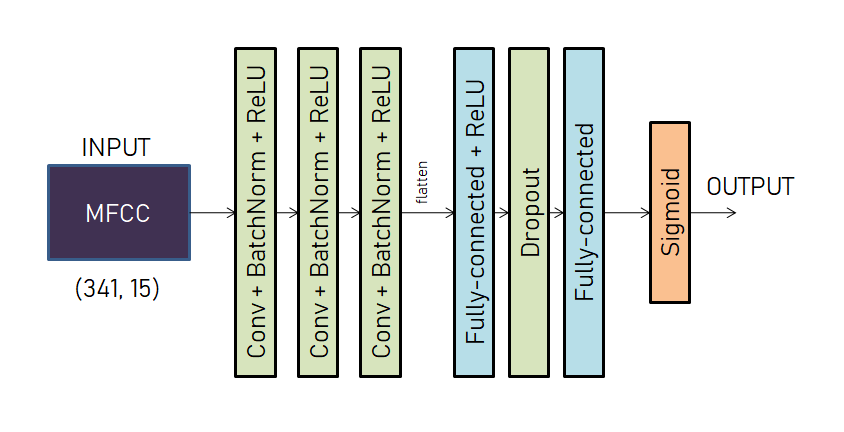


It is worth noting that the architecture is very similar to the one proposed in [1], winners of the Dicova challenge, with a few tweaks in the number of layers, number of filters per layer and the spatial dimensions of the feature maps. We made sure that the model was expressive enough to overfit the training dataset before regularizing the solution to obtain better generalization capabilities. 


We control the training by generating a train-validation partition in a 80-20 proportion. The model was trained for 45 epochs, saving the epoch that returned the highest validation AUC.

___

The CNN model was trained several times to play with the different hyperparameters (learning rate, loss, batch size, etc). The reported model:

- **Loss function**: Focal Loss (Binary Cross Entropy).
- **Optimizer**: Adam.
- **Learning Rate**: 3e-5
- **Regularization**: L2-norm regularization.
- **Batch size**: 256.
- **Xavier weight initialization** [5].

Some techniques were applied to tackle some of the problematiques present in the dataset, such as **weighting each class** inversely proportional to its size (to account for class imbalance) --which was discarded in favor of the Focal Loss--, and the **stratification of the batches** so that the proportion of each class is consistent --discarded due to implementation errors--.

To fasten the proccess, training is carried out with GPU, which for the selected features and architecture took no more than 10 minutes at most.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import copy 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#Example network
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding='valid')
        self.bn1 = nn.BatchNorm2d(128)

        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, padding='valid')
        self.bn2 = nn.BatchNorm2d(256)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)             

        self.fc1 = nn.Linear(512*84*2, 256) 
        self.fc2 = nn.Linear(256, 1)

        self.dropout05 = nn.Dropout(p=0.5)
        self.dropout03 = nn.Dropout(p=0.3)

        self.sigmoid = nn.Sigmoid()
        
    #In forward method we connect layers and define the processing pipeline of the network
    def forward(self, x):
        
        #print("Input: ", x.shape)
        
        x = self.conv1(x)
        #print("Conv1: ", x.shape)
        x = self.pool(self.relu(self.bn1(x)))
        #print("Pool: ", x.shape)

        x = self.conv2(x)
        #print("Conv2: ", x.shape)
        x = self.pool(self.relu(self.bn2(x)))
        #print("Pool: ", x.shape)

        x = self.relu(self.bn3(self.conv3(x)))

        x = x.flatten(1)

        #print("Flatten: ", x.shape)
        x = self.dropout05(self.relu(self.fc1(x)))
        #x = self.relu(self.fc1(x))

        x = self.sigmoid(self.dropout03(self.fc2(x)))
        #print("output: ", x.shape)
        
        
        return x

class ConvNet_ext(ConvNet):

    def __init__(self, epochs=45, lr=3e-5, batch=256):
      
      super().__init__()       
      
      self.lr = lr
      self.epochs = epochs
      self.l2 = 1e-2
      #self.criterion = nn.BCEWithLogitsLoss(reduction='none')
      self.criterion = nn.BCELoss(reduction='none')
      self.gamma = 4 #Focal loss
      self.alpha = 0.25
      self.criterion = nn.BCELoss()

      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.to(self.device)

      self.optim = optim.Adam(self.parameters(), self.lr, weight_decay=self.l2)

      self.batch = batch

      self.scheduler = lr_scheduler.StepLR(self.optim, step_size=20, gamma=0.5)

      self.train_loss_during_training = []
      self.valid_loss_during_training = []

      self.train_auc_during_training = []
      self.valid_auc_during_training = []

    def computeAUC(self,scores,labels):         
        
        scores = scores.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        auc= metrics.roc_auc_score(labels, scores)
        
        return auc    
    
    
    def run_fit(self, train_feats, train_labels):
 
      X = torch.Tensor(train_feats)
      y = torch.Tensor(train_labels)

      best_wts = copy.deepcopy(self.state_dict())
      best_auc = 0
      best_epoch = 0

      dataset = TensorDataset(X, y)      

      trainset, validtest, tr_labels, val_labels = train_test_split(dataset, dataset.tensors[1], test_size=0.2, stratify=y)

      trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch, shuffle=False, num_workers=3)
      validloader = torch.utils.data.DataLoader(validtest, batch_size=self.batch, shuffle=False, num_workers=2)

      for e in range(int(self.epochs)):          
            running_loss = 0.

            train_auc = 0.
            valid_auc = 0.
            
            #TRAINING PHASE
            self.train()
            for images, labels in trainloader:              
                self.optim.zero_grad() 

                images = images.to(self.device)
                labels = labels.to(self.device)

                out = self.forward(images).squeeze()    
                loss = self.criterion(out, labels)
                
                pt = torch.exp(-loss)
                loss = torch.mean(self.alpha * (1-pt)**self.gamma * loss)

                auc = self.computeAUC(out, labels)

                running_loss += loss.item()
                train_auc += auc

                loss.backward()

                self.optim.step()
                self.scheduler.step()
            
            self.train_loss_during_training.append(running_loss/len(trainloader))
            self.train_auc_during_training.append(train_auc/len(trainloader))
                       
            #VALIDATION PHASE
            running_loss = 0. 
            self.eval()

            with torch.no_grad():
                
                for images, labels in validloader: 

                    images = images.to(self.device)
                    labels = labels.to(self.device)
        
                    self.optim.zero_grad()
                    
                    out = self.forward(images).squeeze()
                    
                    loss_valid = self.criterion(out, labels) 
                    pt = torch.exp(-loss_valid)
                    loss_valid = torch.mean(1 * (1-pt)**self.gamma * loss_valid)
                    
                    val_auc = self.computeAUC(out, labels)                    

                    valid_auc += val_auc

                    running_loss += loss_valid.item()

            val_auc_epoch = valid_auc / len(validloader)

            if (val_auc_epoch > best_auc) and (e > 0):
                      best_auc = val_auc_epoch
                      best_wts = copy.deepcopy(self.state_dict())
                      best_epoch = e       

            self.valid_loss_during_training.append(running_loss/len(validloader))
            self.valid_auc_during_training.append(valid_auc/len(validloader))

            if(e % 1 == 0): 
                
                print("EPOCH %d | Training loss: %.4f" %(e, self.train_loss_during_training[-1]),
                      " | Validation loss: %.4f" %(self.valid_loss_during_training[-1]),
                      " | Training AUC: %.4f | Validation AUC: %.4f |" %(train_auc/len(trainloader), val_auc_epoch))     
                            
      print("FINISHED TRAINING\nBest epoch %i | Best AUC = %4.4f " %(best_epoch, best_auc))
      self.load_state_dict(best_wts)

      return

    def validate(self,x_val):

      self.eval()
      x_val = np.array(x_val)
      X = torch.Tensor(x_val[np.newaxis, ...]).to(self.device)

      y_scores = self.forward(X).tolist()

      return y_scores[0][0]  

cuda:0


### Ensemble method

In the following cell we instantiate the Ensemble class. It is initialized with the chosen models passed as arguments, with the condition of all of them having a ```run_fit```method to train it. 

The output is generated as **the averaged probabilities of the individual models**. 

____

In the experiments carried out below, we created an ensemble of a Random Forest classifier, a Logistic Regressor and a Multilayer Perceptron. The particular parameters of each approach were validated separately before creating the ensemble.

Three approaches have been tested to address the contribution of each of the models to the calculation of output: 

**1. Average (Avg):** 

This approach assumes that the performance of the three models is similar so that the weight for each of them is identical, thus computing the arithmetic mean of the three models for the calculation of the output.


**2. Weighted Average 1 (W Avg 1):** 

When experimenting with each of the models separately, a different performance was observed for each of the models, with the best model being the MLP model with an AUC value of 66.96 and the worst being the LR with a value of 58.93. Therefore, it has been decided to give more weight to those models that individually perform better. For this purpose, the following formula has been applied to calculate the weights ($p_{model}$) based on the AUC performance: 

$$
p_{model} = \frac{{AUC_{model}}}{{AUC_{LR}+AUC_{RF}+AUC_{MLP}}}
$$

**3. Weighted Average 2 (W Avg 2):** 

Because the gap between the best and worst performance is only 8 points, the weight given to each of the models with the above approach is 1/3, the result being virtually indentical to the computation of the arithmetic mean. Therefore, we wanted to exaggerate the weight differences by using a weight based on the min-max formula shown below, in which a first weight ($w_{model} \in W$) is calculated and then normalised dividing by the mean of $W$ ($\bar{W}$):

$$
w_{model}=\frac{AUC_{model}-AUC_{min}}{AUC_{max}-AUC_{min}} 
$$

$$
$$

$$
p_{model} =\frac{w_{model}}{\bar{W}}
$$


**4. Weighted Average 3 (W Avg 3):** 

The above approach eliminates the contribution of the worst model regardless of its performance, so we also wanted to assess that all models with an AUC greater than 50% were weighted in the final result.

$$
w_{model}=\left\{\begin{array}{ll}0 & \text { if } AUC_{model} < 50 \\ \frac{AUC_{model}-50}{AUC_{\max }-50} & \text { if } AUC_{model} \geqslant 50\end{array}\right.
$$

$$
$$
$$
$$

$$
p_{model} =\frac{w_{model}}{\bar{W}}
$$

The following table shows the calculated weights in each approach for the models:
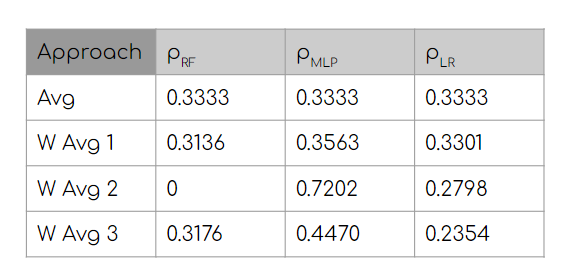

In [ ]:
# Majority Voting Ensemble
class MajorityVotingEnsemble:
    def __init__(self, models):
        self.models = models

    def fit(self, x_train, y_train):
        for model in self.models:
            model.run_fit(x_train, y_train)

    def validate(self, x_val):
        y_scores = [model.validate(x_val) for model in self.models]

        #AVERAGE
        #y_scores_mean = np.mean(y_scores, axis=0)

        #WEIGHTED AVERAGE
        #weights = [0.3301, 0.3136, 0.3563]  #WA 1
        weights = [0.2798, 0, 0.7202]        #WA 2
        weights = [0.3176, 0.4470, 0.2354]   #WA 3

        y_scores_mean =  [ weights[0] *y_scores[0][0] +   weights[1]*y_scores[1][0] + weights[2]* y_scores[2][0] ]
        
        return y_scores_mean

# Results

In the following cells, the methods are trained and evaluated. The results for each approach are shown at the end of each block. To facilitate the comparison for the later discussion, the summary of results are shown in the table below:

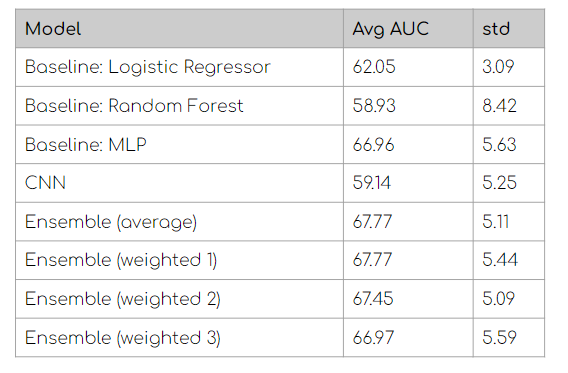

## Baseline 1: Logistic regression
Scikit-learn is used to train the machine learning models. 
This is the first oficial baseline.
You shoul create a cell like this for every model you build.

In [ ]:
'''
========= Logistic regression classifier ======================

TO DO: Create a copy of these cells with the model and configuration you chose for
your project. 

TO SUBMIT: The output files 'val_roc_plot.pdf' and 'val_summary_metrics.pdf' 
for each of the experiments analysed should be include in the report.
'''

output_dir= challengedir + 'results_lr'
train_config= challengedir + 'conf/train_lr.conf'
results_file_roc = output_dir + '/val_roc_plot.pdf'
results_file_scores = output_dir + '/val_summary_metrics.txt'

%mkdir -p $output_dir
%cd $challengedir

/content/drive/.shortcut-targets-by-id/15_WK_SAr1XBy5IimpDyYjyqR_O8T_9rA/FINAL_PROJECT


In [ ]:
'''
Run the training, validation and scoring. The three following cells are the same 
for every model.
'''

for fold in range(1, 6):
	print('doing fold',fold)
	%mkdir -p $output_dir/fold_${fold}
	%cp $datadir/feats.scp $datadir/fold_${fold}/
	# Train
	%run -i train.py	-c $train_config -d $datadir/fold_$fold -o $output_dir/fold_$fold
	# Validate
	%run -i infer.py --modelfil $output_dir/fold_$fold/model.pkl --featsfil $datadir/fold_$fold/feats.scp --file_list $datadir/fold_$fold/val.scp --outfil $output_dir/fold_$fold/val_scores.txt
	# Score
	%run -i scoring.py --ref_file $datadir/fold_$fold/val_labels --target_file $output_dir/fold_$fold/val_scores.txt --output_file $output_dir/fold_$fold/val_results.pkl
	
	
# Produce the files for the leaderboard (in the official challenge). These files should be used to describe the results in your report. 
%cat $output_dir/fold_1/val_scores.txt $output_dir/fold_2/val_scores.txt $output_dir/fold_3/val_scores.txt $output_dir/fold_4/val_scores.txt $output_dir/fold_5/val_scores.txt > $output_dir/val_scores_allfolds.txt
# summarize all folds performance
%run -i summarize.py $output_dir

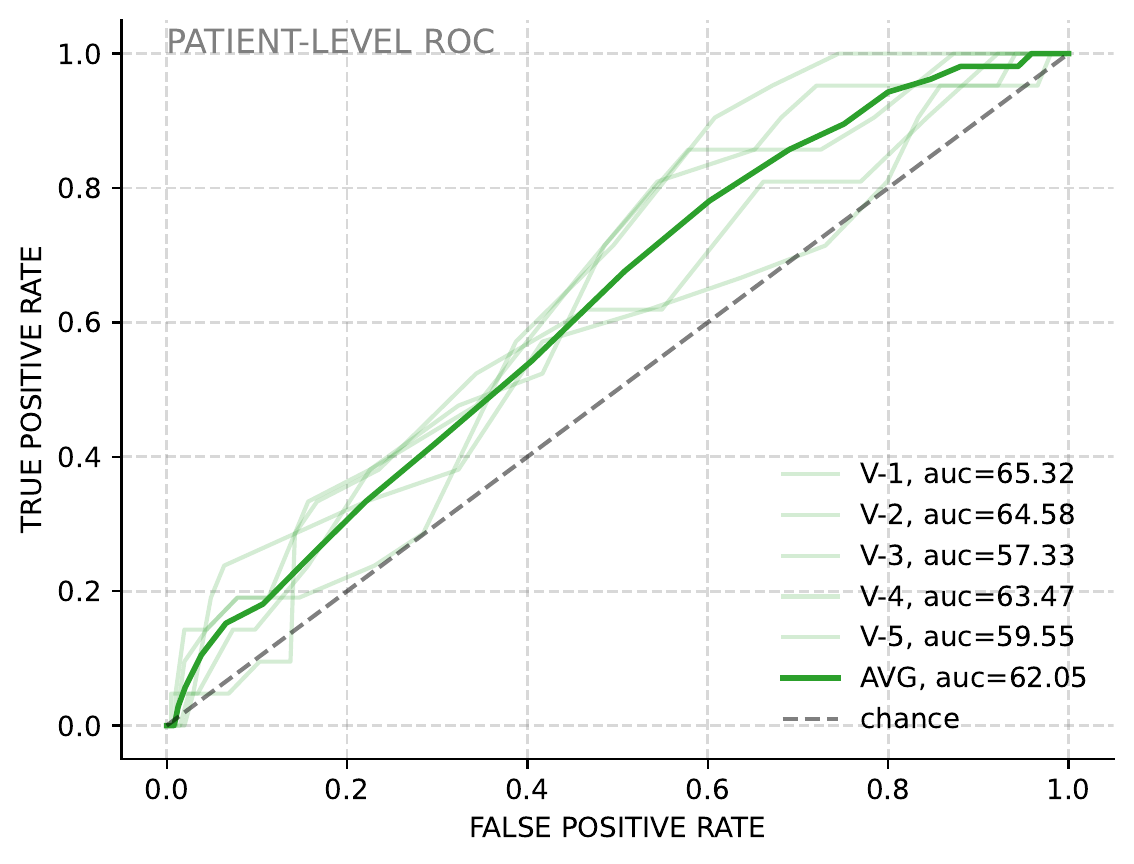

In [ ]:
'''
Display the results.
'''

images = convert_from_path(results_file_roc)
images[0]  # first page


In [ ]:
with open(results_file_scores, 'r') as f:
    lines = f.read().split('\n')
   
for line in lines[:-1]:
    print(line)

'''

TO DO: You can also use other tools to show your results. Remember to explain your results thoroughly.

'''


Sensitivities: 80.95 90.48 80.95 85.71 80.95
Specificities: 45.59 39.22 20.1 42.16 33.82
AUCs: 65.32 64.58 57.33 63.47 59.55
Average sensitivity: 83.81 standard deviation:3.81
Average specificity: 36.18 standard deviation:8.92
Average AUC: 62.05 standard deviation:3.09


'\n\nTO DO: You can also use other tools to show your results. Remember to explain your results thoroughly.\n\n'

## Baseline 2: Random Forest.
This is the second oficial baseline.
You shoul create a cell like this for every model you build.

In [ ]:
'''
========= Random Forest classifier ======================
TO DO: Create a copy of this cell with the model and configuration you chose for
your project. 

TO SUBMIT: The output files 'val_roc_plot.pdf' and 'val_summary_metrics.pdf' 
for each of the experiments analysed should be include in the report.
'''

output_dir='results_rf'
train_config='conf/train_rf.conf'
results_file_roc = output_dir + '/val_roc_plot.pdf'
results_file_scores = output_dir + '/val_summary_metrics.txt'

%mkdir -p $output_dir
%cd $challengedir


/content/drive/.shortcut-targets-by-id/15_WK_SAr1XBy5IimpDyYjyqR_O8T_9rA/FINAL_PROJECT


In [ ]:
'''
Run the training, validation and scoring. The three following cells are the same 
for every model.
'''

for fold in range(1, 6):
	print('doing fold',fold)
	%mkdir -p $output_dir/fold_${fold}
	%cp $datadir/feats.scp $datadir/fold_${fold}/
	# Train
	%run -i train.py	-c $train_config -d $datadir/fold_$fold -o $output_dir/fold_$fold
	# Validate
	%run -i infer.py --modelfil $output_dir/fold_$fold/model.pkl --featsfil $datadir/fold_$fold/feats.scp --file_list $datadir/fold_$fold/val.scp --outfil $output_dir/fold_$fold/val_scores.txt
	# Score
	%run -i scoring.py --ref_file $datadir/fold_$fold/val_labels --target_file $output_dir/fold_$fold/val_scores.txt --output_file $output_dir/fold_$fold/val_results.pkl
	
	
# Produce the files for the leaderboard (in the official challenge). These files should be used to describe the results in your report. 
%cat $output_dir/fold_1/val_scores.txt $output_dir/fold_2/val_scores.txt $output_dir/fold_3/val_scores.txt $output_dir/fold_4/val_scores.txt $output_dir/fold_5/val_scores.txt > $output_dir/val_scores_allfolds.txt
# summarize all folds performance
%run -i summarize.py $output_dir

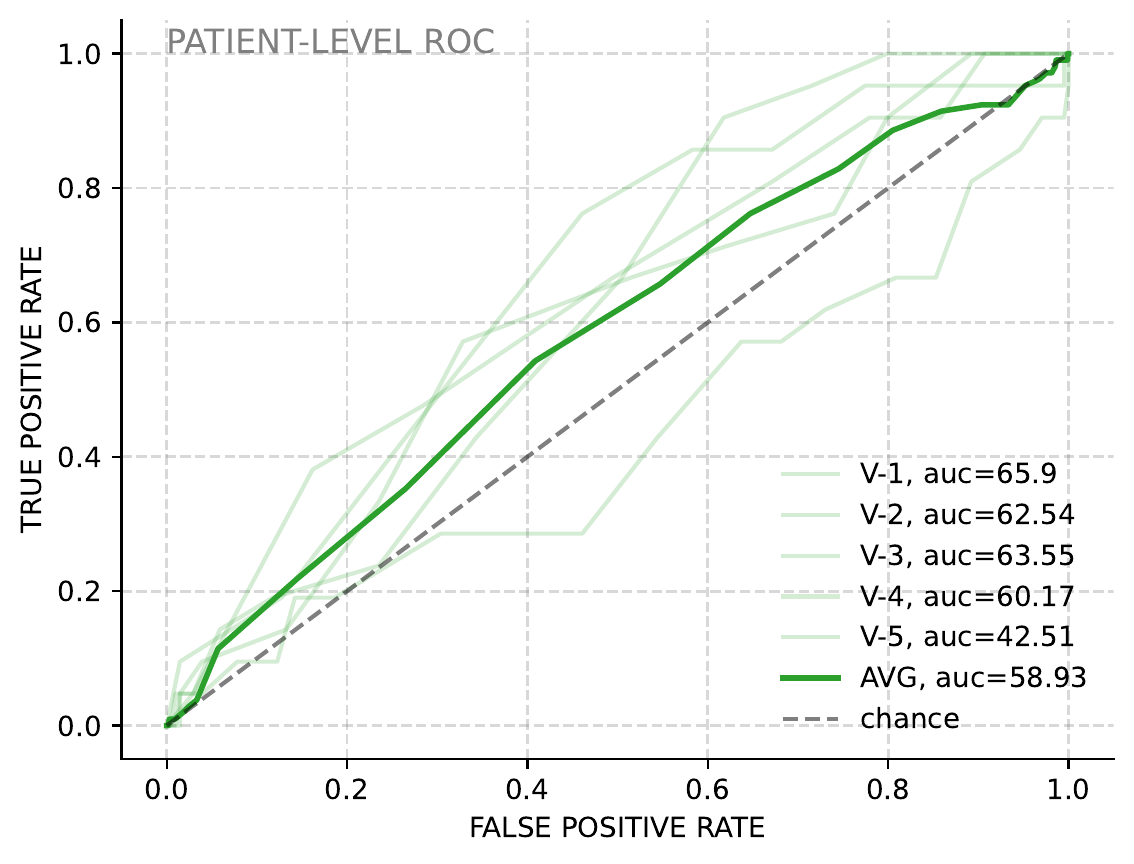

In [ ]:
'''
Display the results.
'''

images = convert_from_path(results_file_roc)
images[0]  # first page



In [ ]:
with open(results_file_scores, 'r') as f:
    lines = f.read().split('\n')
   
for line in lines[:-1]:
    print(line)

'''

TO DO: You can also use other tools to show your results. Remember to explain your results thoroughly.

'''


Sensitivities: 85.71 90.48 80.95 90.48 80.95
Specificities: 41.67 38.24 32.84 20.1 10.78
AUCs: 65.9 62.54 63.55 60.17 42.51
Average sensitivity: 85.71 standard deviation:4.26
Average specificity: 28.73 standard deviation:11.59
Average AUC: 58.93 standard deviation:8.42


'\n\nTO DO: You can also use other tools to show your results. Remember to explain your results thoroughly.\n\n'

## Baseline 3. Multilayer Perceptron.
This is the third oficial baseline.
You shoul create a cell like this for every model you build.

In [ ]:
class MLP(sklearnModel):
  def __init__(self, model_args): 
    super().__init__()        
    self.classifier = MLPClassifier(
        hidden_layer_sizes=model_args['hidden_layer_sizes'],solver=model_args['solver'],
        alpha=model_args['alpha'],learning_rate_init=model_args['learning_rate_init'], 
        verbose=model_args['verbose'], activation="relu", early_stopping=True, 
        max_iter=int(50), random_state=model_args['random_state'])

In [ ]:
'''
========= Multilayer perceptron classifier ======================
TO DO: Create a copy of this cell with the model and configuration you chose for
your project. 

TO SUBMIT: The output files 'val_roc_plot.pdf' and 'val_summary_metrics.pdf' 
for each of the experiments analysed should be include in the report.
'''

output_dir='results_mlp'
train_config='conf/train_mlp.conf'
results_file_roc = output_dir + '/val_roc_plot.pdf'
results_file_scores = output_dir + '/val_summary_metrics.txt'

%mkdir -p $output_dir
%cd $challengedir



/content/drive/.shortcut-targets-by-id/15_WK_SAr1XBy5IimpDyYjyqR_O8T_9rA/FINAL_PROJECT


In [ ]:
'''
Run the training, validation and scoring. The three following cells are the same 
for every model.
'''

for fold in range(1, 6):
	print('doing fold',fold)
	%mkdir -p $output_dir/fold_${fold}
	%cp $datadir/feats.scp $datadir/fold_${fold}/
	# Train
	%run -i train.py	-c $train_config -d $datadir/fold_$fold -o $output_dir/fold_$fold
	# Validate
	%run -i infer.py --modelfil $output_dir/fold_$fold/model.pkl --featsfil $datadir/fold_$fold/feats.scp --file_list $datadir/fold_$fold/val.scp --outfil $output_dir/fold_$fold/val_scores.txt
	# Score
	%run -i scoring.py --ref_file $datadir/fold_$fold/val_labels --target_file $output_dir/fold_$fold/val_scores.txt --output_file $output_dir/fold_$fold/val_results.pkl
	
	
# Produce the files for the leaderboard (in the official challenge). These files should be used to describe the results in your report. 
%cat $output_dir/fold_1/val_scores.txt $output_dir/fold_2/val_scores.txt $output_dir/fold_3/val_scores.txt $output_dir/fold_4/val_scores.txt $output_dir/fold_5/val_scores.txt > $output_dir/val_scores_allfolds.txt
# summarize all folds performance
%run -i summarize.py $output_dir

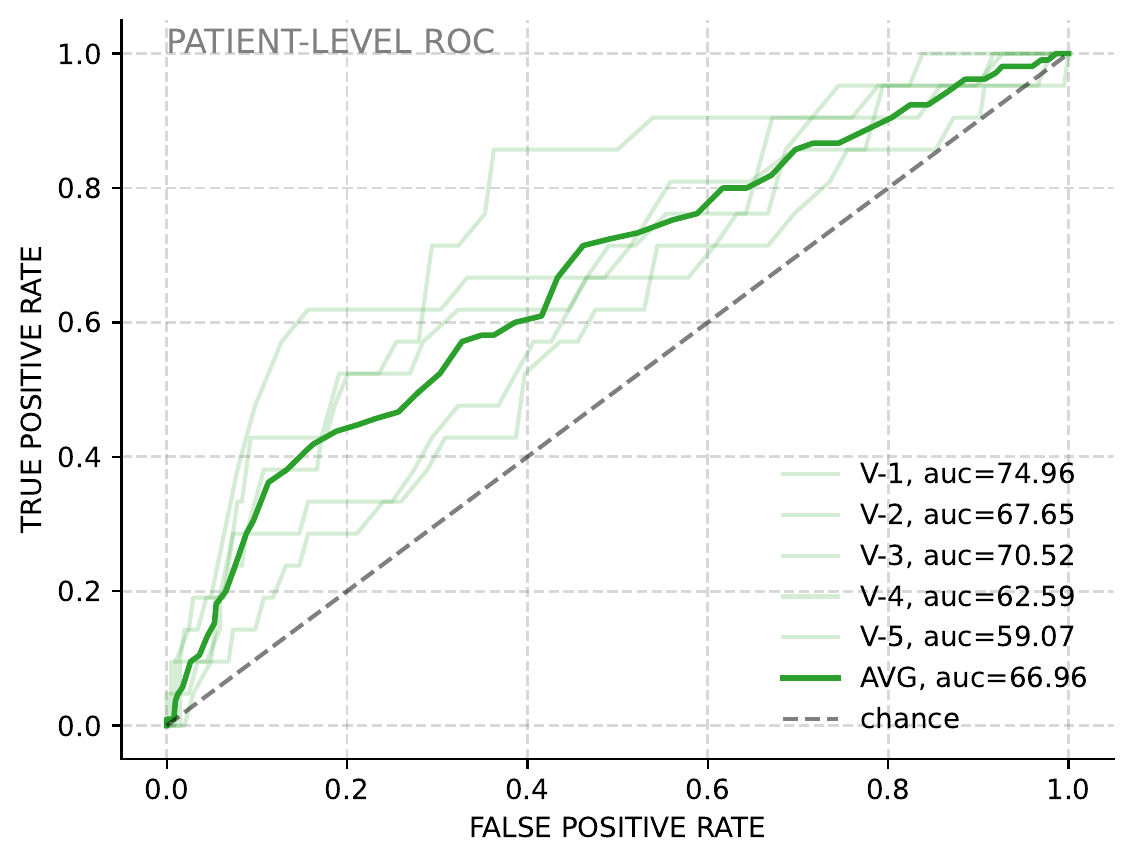

In [ ]:
'''
Display the results.
'''

images = convert_from_path(results_file_roc)
images[0]  # first page


In [ ]:
with open(results_file_scores, 'r') as f:
    lines = f.read().split('\n')
   
for line in lines[:-1]:
    print(line)

'''

TO DO: You can also use other tools to show your results. Remember to explain your results thoroughly.

'''


Sensitivities: 85.71 90.48 80.95 85.71 80.95
Specificities: 63.73 32.84 44.12 31.37 26.47
AUCs: 74.96 67.65 70.52 62.59 59.07
Average sensitivity: 84.76 standard deviation:3.56
Average specificity: 39.71 standard deviation:13.33
Average AUC: 66.96 standard deviation:5.63


'\n\nTO DO: You can also use other tools to show your results. Remember to explain your results thoroughly.\n\n'

## Proposal 1: CNN

In the following cells we train and evaluate the Convolutional Neural Network defined above. 


In [ ]:
'''
CNN
'''
output_dir='results_cnn2'
train_config='conf/train_cnn.conf'
results_file_roc = output_dir + '/val_roc_plot.pdf'
results_file_scores = output_dir + '/val_summary_metrics.txt'

%mkdir -p $output_dir
%cd $challengedir

/content/drive/.shortcut-targets-by-id/15_WK_SAr1XBy5IimpDyYjyqR_O8T_9rA/FINAL_PROJECT


In [ ]:
'''
Run the training, validation and scoring. The three following cells are the same 
for every model. 
'''

for fold in range(1, 6):
	print('doing fold',fold)
	%mkdir -p $output_dir/fold_${fold}
	%cp $datadir/feats.scp $datadir/fold_${fold}/
	# Train
	%run -i train_cnn_indentationIssues.py	-c $train_config -d $datadir/fold_$fold -o $output_dir/fold_$fold
	# Validate
	%run -i infer.py --modelfil $output_dir/fold_$fold/model.pkl --featsfil $datadir/fold_$fold/feats.scp --file_list $datadir/fold_$fold/val.scp --outfil $output_dir/fold_$fold/val_scores.txt
	# Score
	%run -i scoring.py --ref_file $datadir/fold_$fold/val_labels --target_file $output_dir/fold_$fold/val_scores.txt --output_file $output_dir/fold_$fold/val_results.pkl
	
	
# Produce the files for the leaderboard (in the official challenge). These files should be used to describe the results in your report. 
%cat $output_dir/fold_1/val_scores.txt $output_dir/fold_2/val_scores.txt $output_dir/fold_3/val_scores.txt $output_dir/fold_4/val_scores.txt $output_dir/fold_5/val_scores.txt > $output_dir/val_scores_allfolds.txt
# summarize all folds performance
%run -i summarize.py $output_dir

In [ ]:
images = convert_from_path(results_file_roc)
images[0]  # first page

In [ ]:
with open(results_file_scores, 'r') as f:
    lines = f.read().split('\n')
   
for line in lines[:-1]:
    print(line)

'''

TO DO: You can also use other tools to show your results. Remember to explain your results thoroughly.

'''

Sensitivities: 80.95 100.0 85.71 80.95 80.95
Specificities: 32.84 0.0 50.98 23.04 43.63
AUCs: 60.29 49.75 63.03 57.85 64.76
Average sensitivity: 85.71 standard deviation:7.38
Average specificity: 30.1 standard deviation:17.79
Average AUC: 59.14 standard deviation:5.25


'\n\nTO DO: You can also use other tools to show your results. Remember to explain your results thoroughly.\n\n'



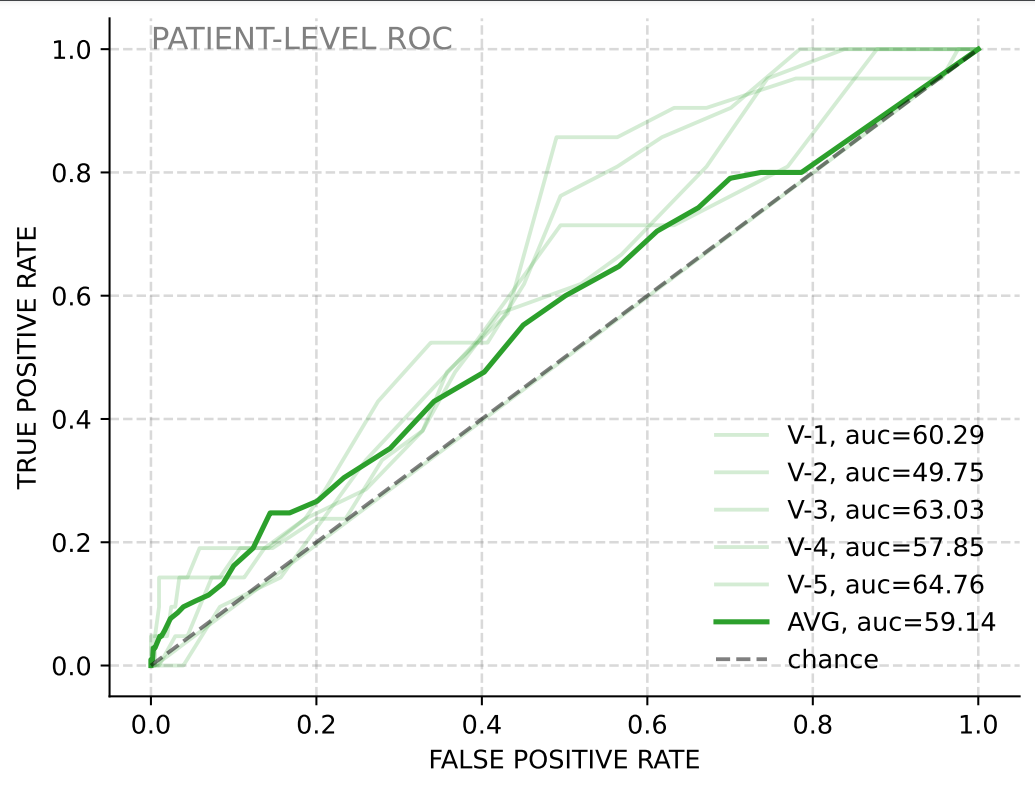

## Proposal 2: Ensemble method

In the following cells we train and evaluate the ensemble method.


In [ ]:
output_dir= challengedir + 'results_ensemble'
train_config= challengedir + 'conf/train_ensemble.conf'
results_file_roc = output_dir + '/val_roc_plot.pdf'
results_file_scores = output_dir + '/val_summary_metrics.txt'
%mkdir -p $output_dir
%cd $challengedir

/content/drive/.shortcut-targets-by-id/15_WK_SAr1XBy5IimpDyYjyqR_O8T_9rA/FINAL_PROJECT


In [ ]:
for fold in range(1, 6):
	print('doing fold',fold)
	%mkdir -p $output_dir/fold_${fold}
	%cp $datadir/feats.scp $datadir/fold_${fold}/
	# Train
	%run -i train.py	-c $train_config -d $datadir/fold_$fold -o $output_dir/fold_$fold
	# Validate
	%run -i infer.py --modelfil $output_dir/fold_$fold/model.pkl --featsfil $datadir/fold_$fold/feats.scp --file_list $datadir/fold_$fold/val.scp --outfil $output_dir/fold_$fold/val_scores.txt
	# Score
	%run -i scoring.py --ref_file $datadir/fold_$fold/val_labels --target_file $output_dir/fold_$fold/val_scores.txt --output_file $output_dir/fold_$fold/val_results.pkl
	
	
# Produce the files for the leaderboard (in the official challenge). These files should be used to describe the results in your report. 
%cat $output_dir/fold_1/val_scores.txt $output_dir/fold_2/val_scores.txt $output_dir/fold_3/val_scores.txt $output_dir/fold_4/val_scores.txt $output_dir/fold_5/val_scores.txt > $output_dir/val_scores_allfolds.txt
# summarize all folds performance
%run -i summarize.py $output_dir

Average

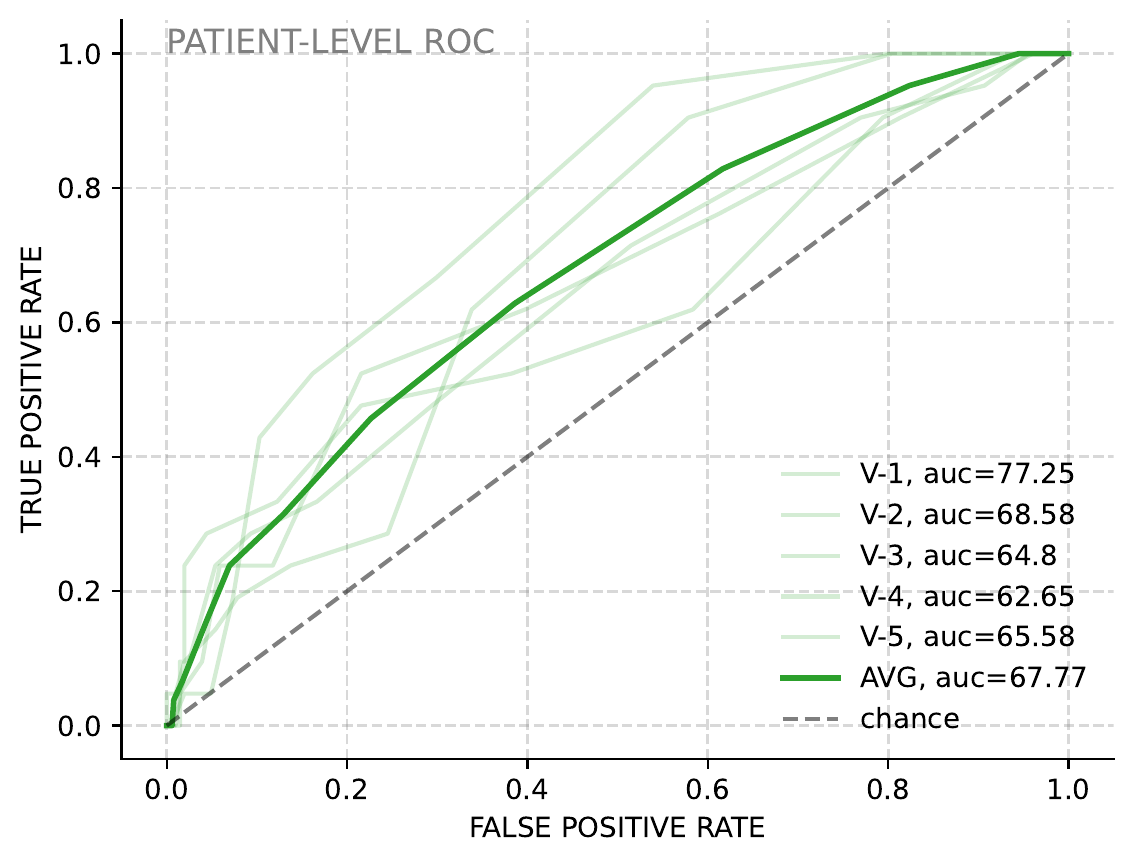

In [ ]:
'''
Display the results.
'''
#AVERAGE
images = convert_from_path(results_file_roc)
images[0]  # first page

In [ ]:
with open(results_file_scores, 'r') as f:
    lines = f.read().split('\n')
   
for line in lines[:-1]:
    print(line)


Sensitivities: 95.24 90.48 90.48 90.48 90.48
Specificities: 46.08 42.16 23.04 20.59 18.63
AUCs: 77.25 68.58 64.8 62.65 65.58
Average sensitivity: 91.43 standard deviation:1.9
Average specificity: 30.1 standard deviation:11.6
Average AUC: 67.77 standard deviation:5.11


Weighting 1

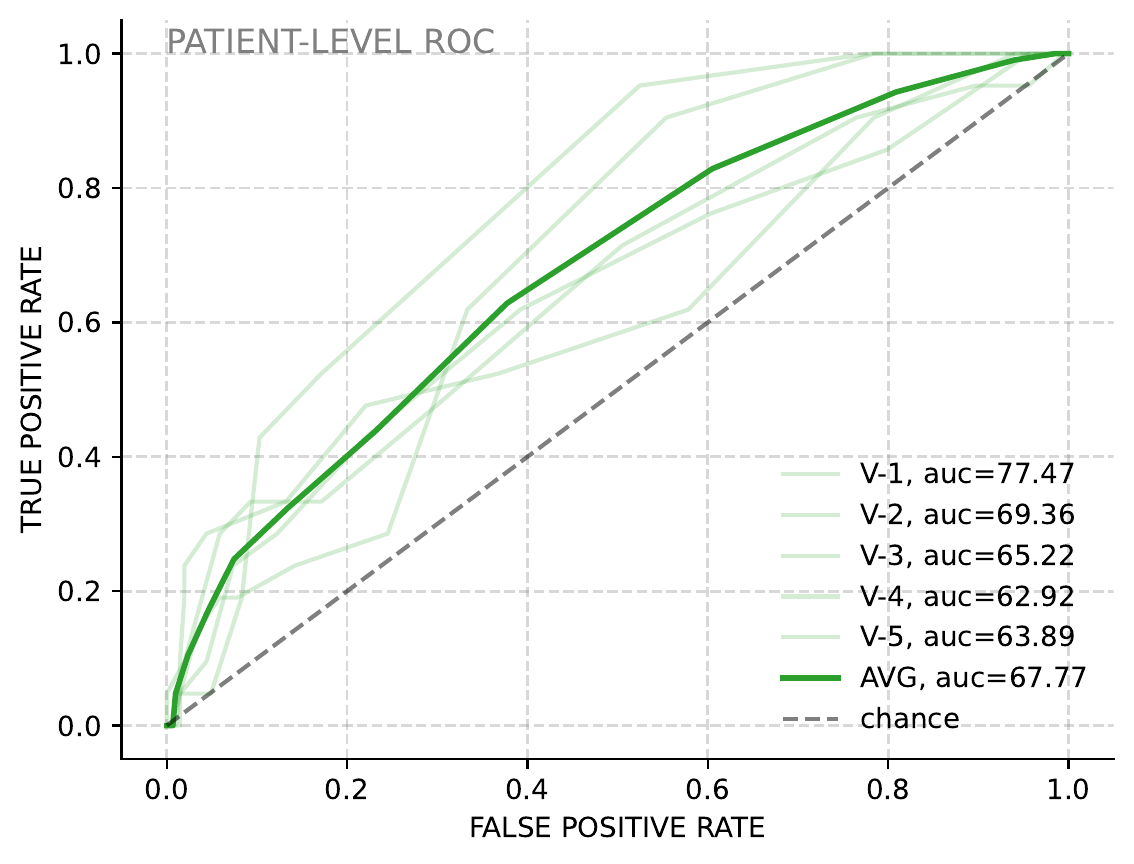

In [ ]:
'''
Display the results.
'''
#WEIGHTING 1
images = convert_from_path(results_file_roc)
images[0]  # first page

In [ ]:
with open(results_file_scores, 'r') as f:
    lines = f.read().split('\n')
   
for line in lines[:-1]:
    print(line)


Sensitivities: 95.24 90.48 90.48 90.48 85.71
Specificities: 47.55 44.61 23.53 21.57 20.1
AUCs: 77.47 69.36 65.22 62.92 63.89
Average sensitivity: 90.48 standard deviation:3.01
Average specificity: 31.47 standard deviation:12.01
Average AUC: 67.77 standard deviation:5.33


Weighting 2

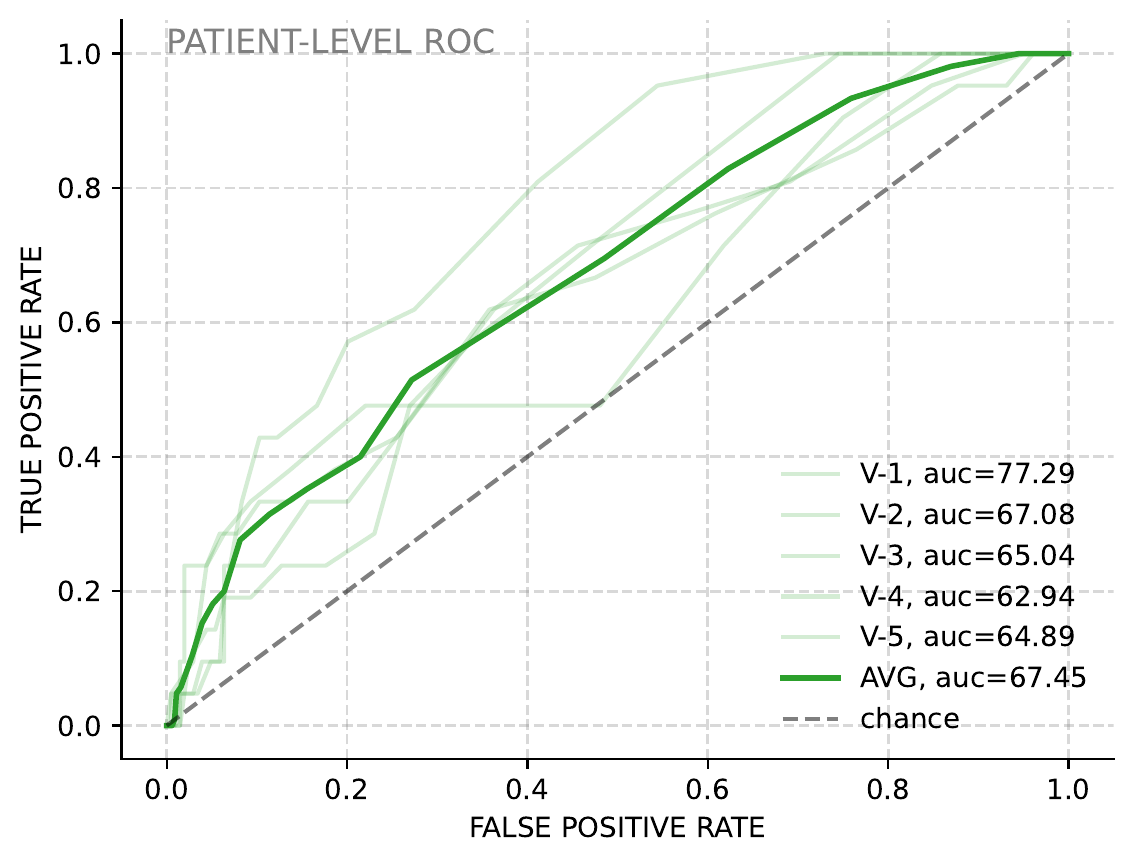

In [ ]:
'''
Display the results.
'''

images = convert_from_path(results_file_roc)
images[0]  # first page

In [ ]:
with open(results_file_scores, 'r') as f:
    lines = f.read().split('\n')
   
for line in lines[:-1]:
    print(line)


Sensitivities: 80.95 85.71 85.71 90.48 80.95
Specificities: 58.82 39.22 23.53 25.0 30.88
AUCs: 77.29 67.08 65.04 62.94 64.89
Average sensitivity: 84.76 standard deviation:3.56
Average specificity: 35.49 standard deviation:12.9
Average AUC: 67.45 standard deviation:5.09


Weighting 3

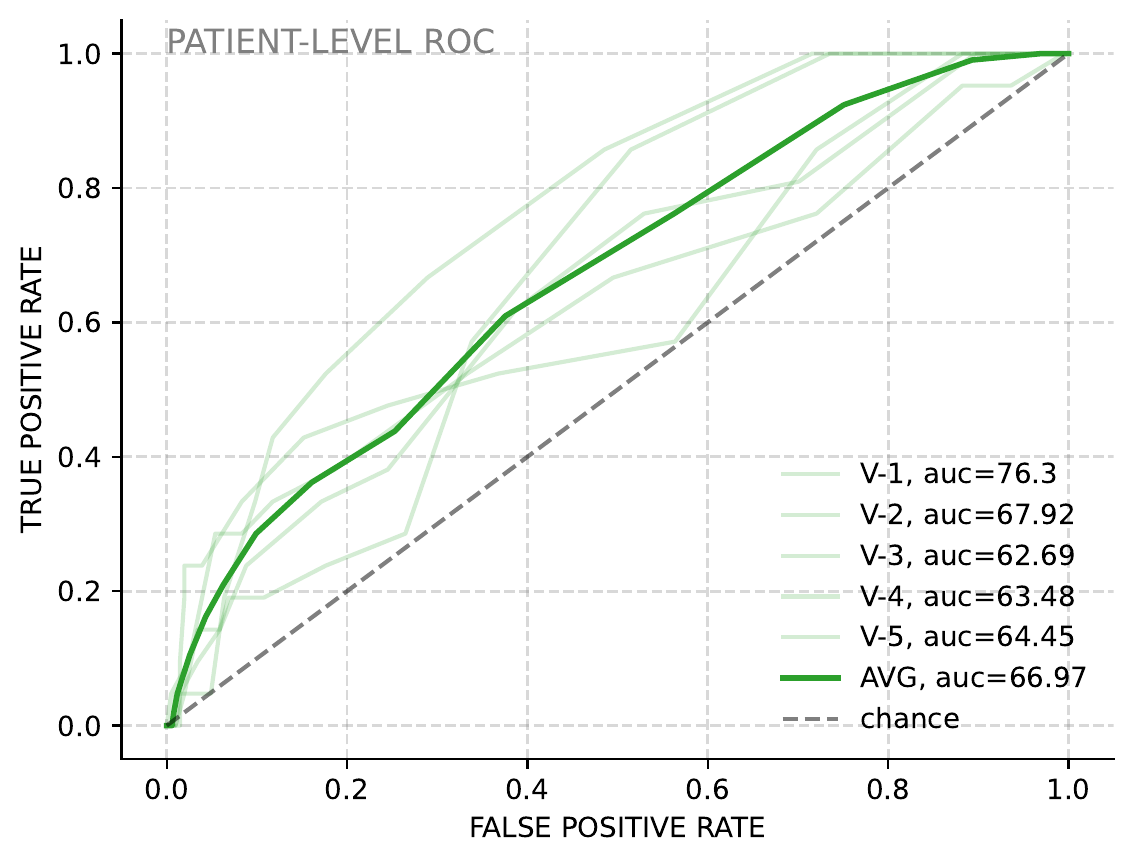

In [ ]:
'''
Display the results.
'''
images = convert_from_path(results_file_roc)
images[0]  # first page

# Discussion


**On the CNN**

The best performing CNN-model (among all the experiments carried out) achieved a final average AUC of 59.14. This is value is significantly lower than the baseline MLP and LR (AUC=66.96 and AUC=62.05 respectively) despite being the approach that obtained the best results in the original Dicova challenge [1]. A few hypothesis were formulated to explain this:

- **Lack of data**: the dataset used in this project is much smaller than the original one. Data-hungry neural networks require large amounts of data to properly optimize the parameters, even if the proposed architecture does not present a lot of depth. Due to the need of splitting each fold into train and validation, the optimization was done with very few samples (around 700). We encountered overfitting problems and an overoptimistic estimation of the test AUCs based on validation --that is, the validation AUCs were much better than the test ones--. A solution we proposed in this regard was data augmentation over the original .wav files, but the structure of the code was not very friendly to implement the changes.

- **Audio as images**: while in the Challenge it was a fairly common idea to extract the MFCC and treat it as an image [1], [2], [4], it is obvious that some information is lost when translating the data between domains. It is interesting to realize that, among the popular proposals, in none the raw audio is processed directly, with for example a 1D-CNN or a LSTM. Generating the spectrogram comes with the advantage of standarizing the input size of all the samples, but the full potential of the CNNs is not explored with this kind of representation.  

The difference in AUC between the best and worst fold is almost 25, which is also a symptom of working with small data, as the variability is inversely proportional to the corpus size [3] (the standard deviation in the AUCs was 5.25, near the average of all the proposals). Due to this fact, the validation scores are not reliable enough to control the training properly. We suspect that the best performing test folds were more similar to the corresponding training set than to the validation set, as we didn't find a direct relationship between the AUCs obtained in development and in test. 

The fold in which we obtained the worst results the CNN was performing below chance (AUC=49.75): the sensitivity in this case was 100%, while the specifity or True Negative Rate was 0.0, which implies that the model classified every patient as Covid-positive. 

The difference on average between specificity (TNR) and sensitivity (TPR), 30.1 and 85.7 respectively, indicates that the model performs better identifying the few positive samples of people with Covid at the cost of overdetecting the condition in healthy patients (lower True Negative). This is counterintuitive in the sense that, due to the class imbalance, we would expect a bias towards classifying everything in class 0 (no Covid). This may be a consequence of optimizing the focal loss version of the binary cross entropy, as the samples correctly classified have a lesser impact in the loss values, putting more attention on errors, which are more likely to happen with class 1.

In the end, our CNN proposal only performed a little bit better than the Random Forest (baseline), for which we conclude that the neural network approach was not suitable for our scenario.

____


**On the Ensemble method**

The idea behind the ensemble was to improve the results by cross-validating the important parameters of the classifiers and then average the output probabilities for class 1. We chose the three methods from the baseline to carry out the ensembling and we performed different weighting to assess the importance of the contribution of each method.

The ensemble demonstrates that the combination of models produces better results than individual models as all of them outperform the baselines. Furthermore, it has been observed that not always the model that performs best individually is the one that performs best as a whole.

As the heterogeneity in the weights increases in each of the approaches, the performance worsens. Thus, the arithmetic mean and the weighted 1 (which both have very similar values in the weights) have been found to be the models with the best AUC.

The ensemble turned out to be more robust than the CNN in the sense that no fold presented a behavior or 100% sensitivity-0% specificity, although in fold 3 there were signs of this happening. Due to the computational cost of having to train each model with 5 folds we had to keep to number of ensembled methods up to three, so we can only speculate if adding more would result in any improvement, specially if we removed the ones returning the poorest AUC.

# Conclusions and further work


By replicating the winning approach of the DiCOVA challenge we aimed to assess the validity of the solution rather than to benchmark performance with more novel architectures. As the performance we obtained was much worse --the winners obtained AUC=87.07, contrasting our AUC=59.14--, and after comparing closely the impact the differences may have had in the results, we identified that the dataset we used was several orders smaller than the original. In the Deep Learning paradigm, the data are more important than the models, and a CNN solution was not suitable in our scenario. 


Regarding the ensemble method, the results were improved with respect to the stand-alone methods by combining the ouputs of the individual classifiers with weights proportional to their performance.


Future lines of work involve gathering more data from the original dataset or applying data augmentation at the audio level, the selection of better performing models for the ensemble method and the fine-tuning of hyperparameters. 

# End of DICOVA.

# References

[1] Mahanta, S.K., Jain, S., & Kaushik, D. (2021). The Brogrammers DiCOVA 2021 Challenge System Report.

[2] Chang, J., Cui, S., & Feng, M. (2021). DiCOVA-Net: Diagnosing covid-19 using acoustics based on deep residual network for the DiCOVA challenge 2021. arXiv preprint arXiv:2107.06126.

[3] Rutowski, T., Harati, A., Shriberg, E., Lu, Y., Chlebek, P., & Oliveira, R. (2022). Toward Corpus Size Requirements for Training and Evaluating Depression Risk Models Using Spoken Language. Interspeech.

[4] Singh, V.P, Kumar, S., Jha, R.S (2021). Samsumg R and D Bangalore DiCOVA 2021 Challenge System Report.

[5] Glorot, X., & Bengio, Y. (2010, March). Understanding the difficulty of training deep feedforward neural networks. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256). JMLR Workshop and Conference Proceedings.

[6] Harvill J., Wani Y., Hasegawa-Johnson M., Ahuja1 N., Beiser D., Chestek, D. (2021). UIUC SST DiCOVA 2021 Challenge System Report.